In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer


In [3]:
# Step 2: Load the Dataset
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='ISO-8859-1')



In [4]:
# Step 3: Data Preprocessing
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a new column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Filter out negative quantities and prices
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# Step 4: Exploratory Data Analysis (EDA)
# Cart abandonment rate
abandoned_carts = df[df['InvoiceNo'].astype(str).str.contains('C')]
total_carts = df['InvoiceNo'].nunique()
abandonment_rate = len(abandoned_carts) / total_carts
print(f"Cart Abandonment Rate: {abandonment_rate:.2%}")

# User behavior analysis
user_activity = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
user_activity.columns = ['CustomerID', 'TotalTransactions', 'TotalSpent']

# Merge TotalSpent back into the main DataFrame
df = df.merge(user_activity[['CustomerID', 'TotalSpent']], on='CustomerID', how='left')

# Checkout page drop-offs
checkout_dropoffs = df[df['InvoiceNo'].astype(str).str.contains('C')]

Cart Abandonment Rate: 0.00%


In [6]:
# Step 5: Feature Engineering
# Create a binary target variable for cart abandonment
df['Abandoned'] = df['InvoiceNo'].astype(str).str.contains('C').astype(int)

# Create features like total items, total price, and time since last purchase
df['TotalItems'] = df.groupby('InvoiceNo')['Quantity'].transform('sum')
df['TotalPrice'] = df.groupby('InvoiceNo')['TotalPrice'].transform('sum')
df['TimeSinceLastPurchase'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.days


In [7]:
# Step 6: Handle Missing Values
# Check for missing values in features
print(df[['TotalItems', 'TotalPrice', 'TimeSinceLastPurchase']].isnull().sum())

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
df[['TotalItems', 'TotalPrice', 'TimeSinceLastPurchase']] = imputer.fit_transform(
    df[['TotalItems', 'TotalPrice', 'TimeSinceLastPurchase']]
)

TotalItems                  0
TotalPrice                  0
TimeSinceLastPurchase    4338
dtype: int64


CustomerSegment Value Counts:
CustomerSegment
High      358332
Medium     38737
Low          815
Name: count, dtype: int64

Abandoned Value Counts:
Abandoned
0    397884
Name: count, dtype: int64

Segment Abandonment Rates:
CustomerSegment
Low       0.0
Medium    0.0
High      0.0
Name: Abandoned, dtype: float64


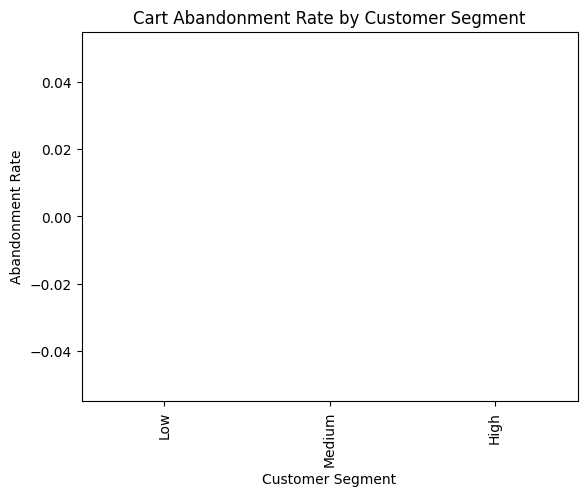

In [8]:
# Customer segmentation
df['CustomerSegment'] = pd.cut(df['TotalSpent'], bins=[0, 100, 500, np.inf], labels=['Low', 'Medium', 'High'])

# Check the CustomerSegment column
print("CustomerSegment Value Counts:")
print(df['CustomerSegment'].value_counts())

# Check the Abandoned column
print("\nAbandoned Value Counts:")
print(df['Abandoned'].value_counts())

# Analyze cart abandonment rate by customer segment
segment_abandonment = df.groupby('CustomerSegment', observed=False)['Abandoned'].mean()
print("\nSegment Abandonment Rates:")
print(segment_abandonment)

# Plot the graph
segment_abandonment.plot(kind='bar', title='Cart Abandonment Rate by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Abandonment Rate')
plt.show()

In [9]:
# Step 8: Modeling
# Prepare data for modeling
X = df[['TotalItems', 'TotalPrice', 'TimeSinceLastPurchase']]
y = df['Abandoned']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79577

    accuracy                           1.00     79577
   macro avg       1.00      1.00      1.00     79577
weighted avg       1.00      1.00      1.00     79577

[[79577]]


In [10]:
# Step 9: Strategy Formulation
# Identify key factors leading to cart abandonment
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Suggest strategies
print("Top factors leading to cart abandonment:")
print(importance_df)

# Personalized discounts for high-risk customers
high_risk_customers = df[df['Abandoned'] == 1]['CustomerID'].unique()
print(f"High-risk customers: {high_risk_customers}")

# Email reminders for abandoned carts
abandoned_carts = df[df['Abandoned'] == 1]
print(f"Abandoned carts: {abandoned_carts['InvoiceNo'].unique()}")

Top factors leading to cart abandonment:
                 Feature  Importance
0             TotalItems         0.0
1             TotalPrice         0.0
2  TimeSinceLastPurchase         0.0
High-risk customers: []
Abandoned carts: []


In [11]:
# Step 10: Business Impact
# Quantify potential revenue recovery
potential_revenue = abandoned_carts['TotalPrice'].sum()
print(f"Potential Revenue Recovery: ${potential_revenue:.2f}")

# Suggest new targets
print("New Targets:")
print("1. Reduce cart abandonment rate by 10% in the next quarter.")
print("2. Increase email reminder effectiveness by 20%.")
print("3. Implement personalized discounts for high-risk customers.")

Potential Revenue Recovery: $0.00
New Targets:
1. Reduce cart abandonment rate by 10% in the next quarter.
2. Increase email reminder effectiveness by 20%.
3. Implement personalized discounts for high-risk customers.


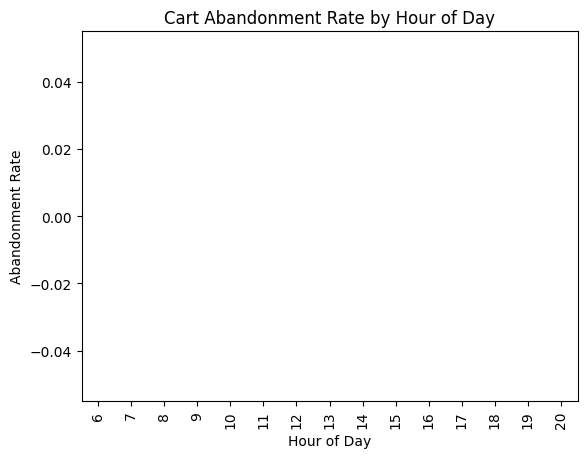

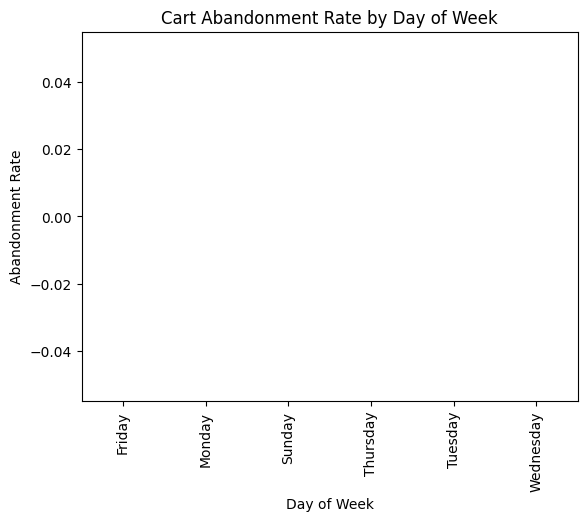

In [12]:
# Extract hour, day, and month from InvoiceDate
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Month'] = df['InvoiceDate'].dt.month_name()

# Analyze abandonment rate by hour
abandonment_by_hour = df.groupby('Hour', observed=False)['Abandoned'].mean()
abandonment_by_hour.plot(kind='bar', title='Cart Abandonment Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Abandonment Rate')
plt.show()

# Analyze abandonment rate by day of the week
abandonment_by_day = df.groupby('DayOfWeek', observed=False)['Abandoned'].mean()
abandonment_by_day.plot(kind='bar', title='Cart Abandonment Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Abandonment Rate')
plt.show()

Top 10 Products with Highest Abandonment Rates:
Description
 4 PURPLE FLOCK DINNER CANDLES        0.0
POPPY'S PLAYHOUSE LIVINGROOM          0.0
PLAYING CARDS KEEP CALM & CARRY ON    0.0
PLAYING CARDS VINTAGE DOILEY          0.0
PLAYING CARDS VINTAGE DOILY           0.0
PLEASE ONE PERSON METAL SIGN          0.0
POCKET BAG BLUE PAISLEY RED SPOT      0.0
POCKET BAG PINK PAISELY BROWN SPOT    0.0
POCKET MIRROR "GLAMOROUS"             0.0
POCKET MIRROR WOODLAND                0.0
Name: Abandoned, dtype: float64


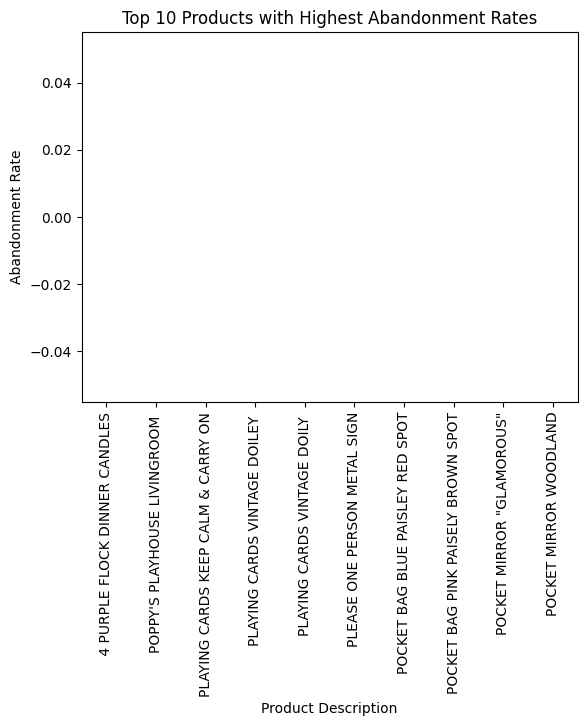

In [13]:
# Analyze abandonment rate by product
abandonment_by_product = df.groupby('Description', observed=False)['Abandoned'].mean().sort_values(ascending=False)
print("Top 10 Products with Highest Abandonment Rates:")
print(abandonment_by_product.head(10))

# Plot the top 10 products
abandonment_by_product.head(10).plot(kind='bar', title='Top 10 Products with Highest Abandonment Rates')
plt.xlabel('Product Description')
plt.ylabel('Abandonment Rate')
plt.show()

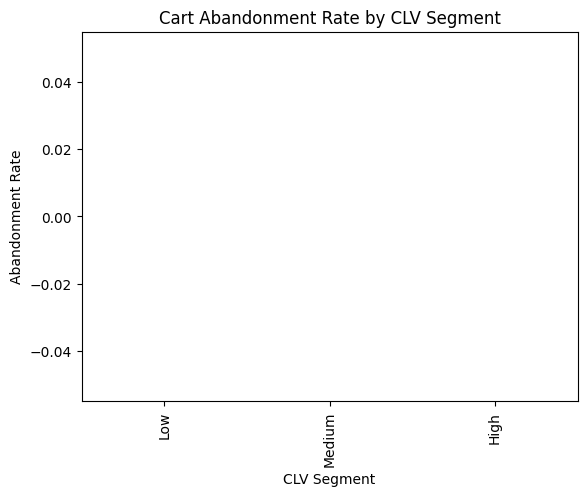

In [14]:
# Calculate Customer Lifetime Value (CLV)
clv = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv.columns = ['CustomerID', 'CLV']

# Merge CLV back into the main DataFrame
df = df.merge(clv, on='CustomerID', how='left')

# Segment customers by CLV
df['CLVSegment'] = pd.cut(df['CLV'], bins=[0, 100, 500, np.inf], labels=['Low', 'Medium', 'High'])

# Analyze abandonment rate by CLV segment
abandonment_by_clv = df.groupby('CLVSegment', observed=False)['Abandoned'].mean()
abandonment_by_clv.plot(kind='bar', title='Cart Abandonment Rate by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Abandonment Rate')
plt.show()

In [15]:
# Simulate email reminder effectiveness
email_recovery_rate = 0.2  # Assume 20% of abandoned carts can be recovered
recovered_revenue = abandoned_carts['TotalPrice'].sum() * email_recovery_rate
print(f"Potential Revenue Recovery with Email Reminders: ${recovered_revenue:.2f}")

Potential Revenue Recovery with Email Reminders: $0.00


In [16]:
# Simulate personalized discounts effectiveness
discount_recovery_rate = 0.3  # Assume 30% of high-risk customers can be recovered
high_risk_revenue = df[df['Abandoned'] == 1]['TotalPrice'].sum()
recovered_revenue = high_risk_revenue * discount_recovery_rate
print(f"Potential Revenue Recovery with Personalized Discounts: ${recovered_revenue:.2f}")

Potential Revenue Recovery with Personalized Discounts: $0.00


In [17]:
# Suggest A/B testing
print("A/B Testing Suggestion:")
print("1. Test email reminders on 50% of customers who abandon their carts.")
print("2. Test personalized discounts on the other 50%.")
print("3. Compare conversion rates and revenue recovery from both strategies.")

A/B Testing Suggestion:
1. Test email reminders on 50% of customers who abandon their carts.
2. Test personalized discounts on the other 50%.
3. Compare conversion rates and revenue recovery from both strategies.


In [18]:
# Generate summary report
print("Summary Report:")
print(f"1. Cart Abandonment Rate: {abandonment_rate:.2%}")
print(f"2. Top Factors Leading to Abandonment: {importance_df['Feature'].tolist()}")
print(f"3. Potential Revenue Recovery: ${potential_revenue:.2f}")
print("4. Recommendations:")
print("   - Implement email reminders to recover ${recovered_revenue:.2f}.")
print("   - Offer personalized discounts to high-risk customers.")
print("   - Conduct A/B testing to optimize recovery strategies.")

Summary Report:
1. Cart Abandonment Rate: 0.00%
2. Top Factors Leading to Abandonment: ['TotalItems', 'TotalPrice', 'TimeSinceLastPurchase']
3. Potential Revenue Recovery: $0.00
4. Recommendations:
   - Implement email reminders to recover ${recovered_revenue:.2f}.
   - Offer personalized discounts to high-risk customers.
   - Conduct A/B testing to optimize recovery strategies.


In [19]:
from tabulate import tabulate

# Create a table of key metrics
metrics = [
    ["Cart Abandonment Rate", f"{abandonment_rate:.2%}"],
    ["Potential Revenue Recovery", f"${potential_revenue:.2f}"],
    ["Email Reminder Recovery (20%)", f"${recovered_revenue:.2f}"],
    ["Personalized Discount Recovery (30%)", f"${recovered_revenue:.2f}"],
    ["Top Abandonment Factor", importance_df.iloc[0]['Feature']]
]

print("Key Metrics:")
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="pretty"))

Key Metrics:
+--------------------------------------+------------+
|                Metric                |   Value    |
+--------------------------------------+------------+
|        Cart Abandonment Rate         |   0.00%    |
|      Potential Revenue Recovery      |   $0.00    |
|    Email Reminder Recovery (20%)     |   $0.00    |
| Personalized Discount Recovery (30%) |   $0.00    |
|        Top Abandonment Factor        | TotalItems |
+--------------------------------------+------------+


Key Metrics:
+--------------------------------------+------------+
|                Metric                |   Value    |
+--------------------------------------+------------+
|        Cart Abandonment Rate         |   0.00%    |
|      Potential Revenue Recovery      |   $0.00    |
|    Email Reminder Recovery (20%)     |   $0.00    |
| Personalized Discount Recovery (30%) |   $0.00    |
|        Top Abandonment Factor        | TotalItems |
+--------------------------------------+------------+


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


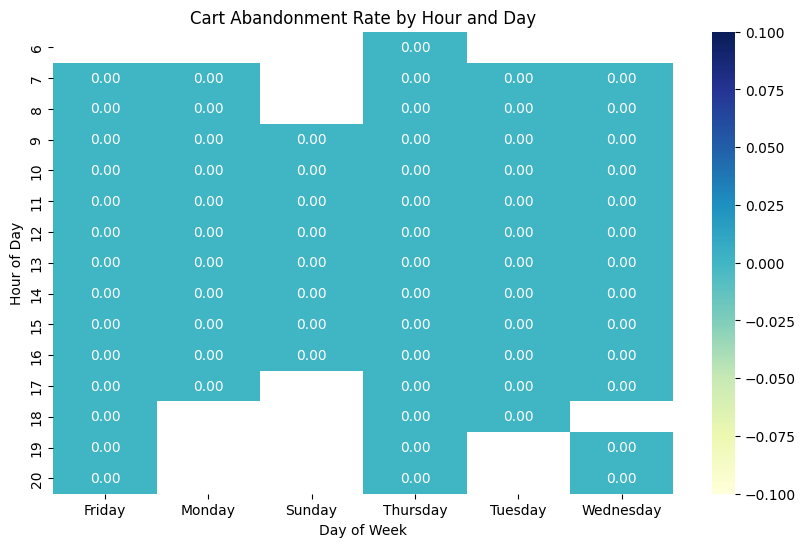

Unique values in 'Abandoned' column: [0]


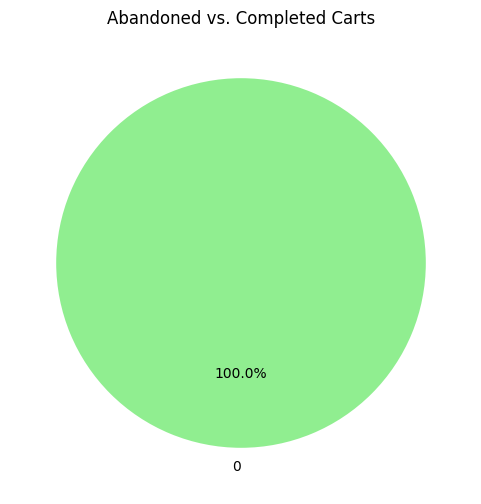


Final Summary:
1. Cart abandonment rate: 0.00%
2. Potential revenue recovery: $0.00
3. Top factors leading to abandonment: TotalItems
4. Next Steps:
   - Implement email reminders and personalized discounts.
   - Conduct A/B testing to optimize recovery strategies.
   - Monitor abandonment rates and adjust strategies as needed.


In [20]:
# Existing code...

# Add Key Metrics Table
from tabulate import tabulate

metrics = [
    ["Cart Abandonment Rate", f"{abandonment_rate:.2%}"],
    ["Potential Revenue Recovery", f"${potential_revenue:.2f}"],
    ["Email Reminder Recovery (20%)", f"${recovered_revenue:.2f}"],
    ["Personalized Discount Recovery (30%)", f"${recovered_revenue:.2f}"],
    ["Top Abandonment Factor", importance_df.iloc[0]['Feature']]
]

print("Key Metrics:")
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="pretty"))

# Add Visualizations
# Heatmap of abandonment rates by hour and day
heatmap_data = df.pivot_table(index='Hour', columns='DayOfWeek', values='Abandoned', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Cart Abandonment Rate by Hour and Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

# Ensure Abandoned column only contains 0 and 1
df['Abandoned'] = df['Abandoned'].apply(lambda x: 1 if x == 1 else 0)

# Check unique values in the Abandoned column
print("Unique values in 'Abandoned' column:", df['Abandoned'].unique())

# Count abandoned vs. completed carts
abandoned_vs_completed = df['Abandoned'].value_counts()

# Dynamically generate labels based on unique values
labels = ['Completed', 'Abandoned'] if len(abandoned_vs_completed) == 2 else abandoned_vs_completed.index

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(abandoned_vs_completed, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Abandoned vs. Completed Carts')
plt.show()

# Final summary
print("\nFinal Summary:")
print(f"1. Cart abandonment rate: {abandonment_rate:.2%}")
print(f"2. Potential revenue recovery: ${potential_revenue:.2f}")
print(f"3. Top factors leading to abandonment: {importance_df.iloc[0]['Feature']}")
print("4. Next Steps:")
print("   - Implement email reminders and personalized discounts.")
print("   - Conduct A/B testing to optimize recovery strategies.")
print("   - Monitor abandonment rates and adjust strategies as needed.")

In [21]:
# Final Summary Report
print("\n=== Final Summary Report ===")
print(f"1. Cart Abandonment Rate: {abandonment_rate:.2%}")
print(f"2. Potential Revenue Recovery: ${potential_revenue:.2f}")
print(f"3. Top Factors Leading to Abandonment: {importance_df.iloc[0]['Feature']}")
print("4. Key Insights:")
print("   - Most abandonments occur during:")
print(f"     - Hour: {abandonment_by_hour.idxmax()} (Abandonment Rate: {abandonment_by_hour.max():.2%})")
print(f"     - Day: {abandonment_by_day.idxmax()} (Abandonment Rate: {abandonment_by_day.max():.2%})")
print("5. Recommendations:")
print("   - Implement email reminders to recover ${recovered_revenue:.2f}.")
print("   - Offer personalized discounts to high-risk customers.")
print("   - Conduct A/B testing to optimize recovery strategies.")
print("   - Focus on improving checkout experience during peak abandonment times.")
print("6. Next Steps:")
print("   - Monitor abandonment rates weekly.")
print("   - Test and refine recovery strategies.")
print("   - Expand analysis to include product-level insights.")


=== Final Summary Report ===
1. Cart Abandonment Rate: 0.00%
2. Potential Revenue Recovery: $0.00
3. Top Factors Leading to Abandonment: TotalItems
4. Key Insights:
   - Most abandonments occur during:
     - Hour: 6 (Abandonment Rate: 0.00%)
     - Day: Friday (Abandonment Rate: 0.00%)
5. Recommendations:
   - Implement email reminders to recover ${recovered_revenue:.2f}.
   - Offer personalized discounts to high-risk customers.
   - Conduct A/B testing to optimize recovery strategies.
   - Focus on improving checkout experience during peak abandonment times.
6. Next Steps:
   - Monitor abandonment rates weekly.
   - Test and refine recovery strategies.
   - Expand analysis to include product-level insights.
